In [1]:
import scipy.io as sio
import numpy as np
import torch
import glob
from core.models.utils.evaluation import eval_atc_all
import trimesh
import os
import matplotlib.pyplot as plt
from transforms3d.euler import euler2mat
os.environ["PYOPENGL_PLATFORM"] = "osmesa"
import pyrender
from core.models.utils.align import ExpSO3

In [2]:
def generate_mesh(point, color1, color2=None, mask=0, weight=0, split=False):
    sm = trimesh.creation.uv_sphere(radius=0.01, count=[6,6])
    nv = sm.vertices.shape[0]
    vtx, faces, tex = [], [], []
    print(point.shape[0])
    
    for i in range(point.shape[0]):
        vtx.append(sm.vertices.copy() + point[i])
        faces.append(sm.faces.copy() + i * nv)
        if not split:
            tex.append(np.ones_like(vtx[-1]) * color1)
        else:
            if type(mask) != int:
                if mask[i,0] == 1:
                    tex.append(np.ones_like(vtx[-1]) * color2)
                elif mask[i,1] == 1:
                    tex.append(np.ones_like(vtx[-1]) * color1)
                elif mask[i,2] == 1:
                    tex.append(np.ones_like(vtx[-1]) * np.array([0.5,0.5,0.5]))
                else:
                    tex.append(np.ones_like(vtx[-1]) * np.array([0.5,0.5,0.5]))
            if type(weight) != int:
                color = color1 * weight[i] + color2 * (1 - weight[i])
                tex.append(np.ones_like(vtx[-1]) * color * 0.99)
    vtx = np.concatenate(vtx, axis=0)
    faces = np.concatenate(faces, axis=0)
    tex = np.concatenate(tex, axis=0)
    mesh = trimesh.Trimesh(vertices=vtx, faces=faces, vertex_colors=tex)
    return mesh

In [16]:
data_path = '/nhome/yuchen_che/pm_result/paint/washing_machine'

In [17]:
file_list = glob.glob(data_path + "/*.mat")
file_n = len(file_list)
segmentation_acc = 0
motion_part_iou = 0
orientation_error = 0
distance_error = 0
overall_iou = 0
epe_error = 0
r = 0
static_axis = torch.tensor([0,0,0,0,0,1,0,0], dtype=torch.float32)
for file in file_list:
    instance = sio.loadmat(file)['pred_data'][0]
    if np.sum((instance['pred_axis'][0][0] - torch.tensor([0,0,0,0,0,1,0,0], dtype=torch.float32).numpy()) ** 2) > 1e-3:
        r += 1
        #print(file)
    gt_lable = instance['GT_label'][0]
    #gt_lable  = -gt_lable + 1
    pred_lable = torch.tensor(instance['pred_label'][0], dtype=torch.int64)
    if pred_lable.flatten().min() == 1:
        pred_lable -= 1
    num_classes = gt_lable.max() - gt_lable.min() + 1
    num_classes = num_classes if num_classes >= pred_lable.max() + 1 else pred_lable.max() + 1
    pred_lable = torch.nn.functional.one_hot(pred_lable.flatten(), num_classes= num_classes).numpy()
    #print(pred_lable.shape[-1])
    gt_axis = instance['GT_axis'][0]
    pred_axis = instance['pred_axis'][0]
    frame_theta = np.repeat(instance['pred_axis'][0][:, np.newaxis, 6:7], repeats=11, axis=1).astype(np.float)
    for i in range(11):
        frame_theta[:, i, :] = frame_theta[:, -1, :] * i / 10
    axis_rotation = ExpSO3(torch.tensor(instance['pred_axis'][0][:, np.newaxis,3:6] * frame_theta/180*np.pi))
    #axis_rotation = axis_rotation[[1,0],...]
    #try:
    eval_result = eval_atc_all(
        pred_axis[:, 3:6].astype(np.float32),
        pred_axis[:, :3].astype(np.float32),
        pred_lable,
        gt_axis[:, 3:6].astype(np.float32),
        gt_axis[:, :3].astype(np.float32),
        gt_lable,
        pc=torch.tensor(np.transpose(instance['input'][0][0], (1,0,2))[:,:,:3]),
        rotation = torch.tensor(axis_rotation),
        )
    segmentation_acc += eval_result['segmentation_mean'].item()
    motion_part_iou += eval_result['motion_part_iou'].item()
    overall_iou += eval_result['overall_iou'].item()
    orientation_error += eval_result['joint_orientation_error_mean'].item()
    distance_error += eval_result['joint_distance_error'].item()
    epe_error += eval_result['end_point_error'].item()
    #except:
    #    print(file, 'fail')
    #    file_n -= 1

segmentation_acc /= file_n
motion_part_iou /= file_n
overall_iou /= file_n
orientation_error /= file_n
distance_error /= file_n
epe_error /= file_n

print(segmentation_acc, motion_part_iou, overall_iou, orientation_error, distance_error, epe_error)


/home/yuchen_che/workspace/CaDeX/cadex_env/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.5703168596540179 0.36121468581683075 0.32012481269441 73.11230657322837 0.15950049060795987 0.019211674427564707


In [11]:
frame_theta

array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]])

In [10]:
data_path = '/nhome/yuchen_che/pm_result/paint/eyeglasses'
file_n = len(file_list)
epe_error = 0
for file in file_list:
    instance = sio.loadmat(file)['pred_data'][0]
    epe_error += instance['epe_err'][0].item()
epe_error /= file_n
epe_error

0.007203891403562998

In [5]:
data_path = '/nhome/datasets/PartMobility/enhance_data/test/washing_machine'
file_list = glob.glob(data_path + "/*.mat")
for file in file_list:
    flag=False
    instance = sio.loadmat(file)['data'][0]
    gt_lable = instance['label'][0]
    axis = instance['axis'][0]
    #pred_lable = torch.tensor(instance['label'][0], dtype=torch.int64)
    if gt_lable.max() != 1 or gt_lable.min() != 0:
        flag=True
        print('parts, ', end='')
    if axis.shape[0] != 1:
        flag=True
        print('axis_num, ', end='')
    if np.any(np.abs(axis[:, -2]) <= 0.314):
        flag=True
        print('axis_type, ', end='')
    if flag:
        print(file)

KeyboardInterrupt: 

In [8]:
instance = sio.loadmat('/nhome/yuchen_che/pm_result/paint/laptop&notebook/laptop&notebook_202.mat')['pred_data'][0]
gt_lable = torch.tensor(instance['GT_label'][0], dtype=torch.int64)
gt_lable = torch.nn.functional.one_hot(gt_lable.flatten()).numpy()
pred_lable = torch.tensor(instance['pred_label'][0], dtype=torch.int64) - 1
pred_lable = torch.nn.functional.one_hot(pred_lable.flatten()).numpy()
gt_axis = instance['GT_axis'][0][1:]
pred_axis = instance['pred_axis'][0][1:]

In [81]:
instance['input'][0].shape

(2048, 11, 6)

In [7]:
pred_lable.min()

0

In [78]:
t = 1
point = instance['input'][0][0][:,t,[1,0,2]]
instance['pred_label'][0].reshape(-1)
label = instance['pred_label'][0].reshape(-1)
mask = np.zeros((instance['GT_label'][0].reshape(-1).max()+1, instance['GT_label'][0].reshape(-1).shape[0]))
for i in range(mask.shape[0]):
    mask[i] = label == i
mesh_mask = generate_mesh(
    point,
    color2=np.array([0.5,1,0.5]),
    color1=np.array([1,0.5,0.5]),
    #weight=cham_x[b,p].flatten(),
    mask=gt_lable,
    split=True)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [16]:
gt_lable

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [14]:
instance['input'][0][0].shape

(2048, 11, 6)

(-0.5, 479.5, 479.5, -0.5)

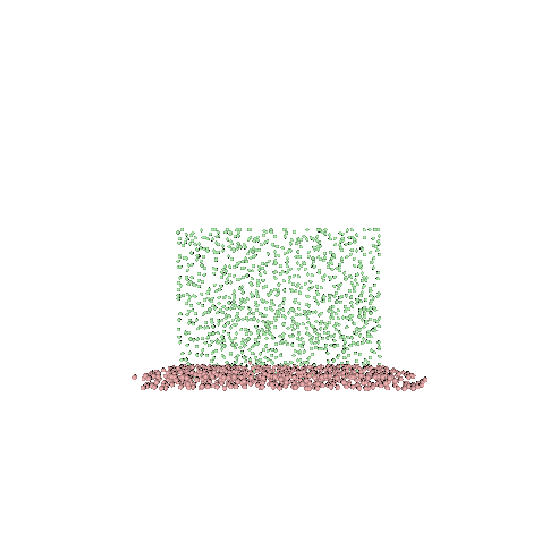

In [23]:
R = euler2mat(-0.*np.pi, -0.2*np.pi, -0.2*np.pi, "rzyx")
camera_pose = np.eye(4)
#camera_pose[:3, :3] = R
camera_pose[:3, 3] = np.array([-0.,0.2,2])
#camera_pose[:3, 3] = R @ camera_pose[:3, 3]
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3, aspectRatio=1.0,)
light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=4.0)

r = pyrender.OffscreenRenderer(480, 480)
scene_mask = pyrender.Scene()
scene_mask.add(pyrender.Mesh.from_trimesh(mesh_mask, material=None))
scene_mask.add(camera, pose=camera_pose)
scene_mask.add(light, pose=camera_pose)
color_mask, depth = r.render(scene_mask)

plt.figure(figsize=(10, 10))
plt.subplot(1,1,1)
plt.imshow(color_mask)
plt.axis('off')

In [18]:
color_mask.shape

(480, 480, 3)

In [39]:
glob.glob('/nhome/yuchen_che/pm_result/paint/**/*.mat', recursive=True)

['/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_47.mat',
 '/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_15.mat',
 '/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_26.mat',
 '/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_45.mat',
 '/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_33.mat',
 '/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_32.mat',
 '/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_43.mat',
 '/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_8.mat',
 '/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_40.mat',
 '/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_36.mat',
 '/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_16.mat',
 '/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_27.mat',
 '/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_46.mat',
 '/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_24.mat',
 '/nhome/yuchen_che/pm_result/paint/eyeglasses/eyeglasses_18.ma